# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

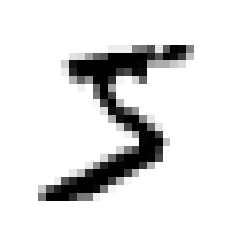

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_img = some_digit.reshape(28, 28)

plt.imshow(some_digit_img, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8)

y[0]

5

In [6]:
# MNIST is already split into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
For start let's make a binary classifier that will indentify single digit - digit 5.

In [7]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation
Following code is roughly equivalent to *Scikit-Learn*'s function `cross_val_score`.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_ix]
    y_train_folds = y_train_5[train_ix]
    
    X_test_folds = X_train[test_ix]
    y_test_folds = y_train_5[test_ix]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This seems pretty good! However, let's check a classifier that always classifies an image as **not 5**.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy! Well, the problem is that just about 10% of the whole dataset are images of 5 (there are 10 numbers in total). Hence the 90% accuracy.

### Confusion Matrix
The idea of a *confusion matrix* is to count the number of times class A is classified as class B and so on. 

To compute the confusion matrix one must first get predicions (here on the train set, let's keep test set aside). We can take predictions for a cross-validation with `cross_val_predict` and pass them to `confusion_matrix`.

For a binary classification the confusion matrix looks like this:

|     | N  | P  |
|-----|----|----|
| N   | TN | FP |
| P   | FN | TP |

Rows are the *actual* class and columns are the predicted class, furthermore
* *P* - *positive* (class)
* *N* - *negative* (class)
* *TN* - *true negative*
* *TP* - *true positive*
* *FN* - *false negative*
* *FP* - *false negative*

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

**Precision** is the accuracy of positive predictions and is defined as $\text{precision} = \frac{TP}{TP + FP}$

*Trivial way to ensure 100% precision is to make single prediction and make sure it's correct.*

**Recall (sensitivity, true positive rate)** is the ratio of positive instances that are correctly detected and is defined as $\text{recall} = \frac{TP}{TP + FN}$

Intuitive notion of precision and recall:
* *precision* - how often is the predictor correct when the actual class is the positive one
* *recall* - how likely does the predictor detect the positive class

In [15]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
precision, recall

(0.8370879772350012, 0.6511713705958311)

Precision and recall are handy but it's even better to have single score based on which we can compare classifiers.

$\mathbf{F_1}$ score is the *harmonic mean* of precision and recall. Regular mean puts the same weight to all values, harmonic mean gives much more importance to lower values. So in order to have high $F_1$ score, both precision and mean must be high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off
*Increasing precision reduces recall and vice versa.*

How does the classification work? The `SGDClassifier`, for instance, computes for each instance a score based on a *decision function*. If this score is greater than *decision threshold*, it assigns the instance to the positive class. Shifting this threshold will likely result a change in precision and recall.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
def predict_some_digit(threshold):
    return (y_scores > threshold)

# Raising the threshold decreases recall
predict_some_digit(threshold=0), predict_some_digit(threshold=8000)

(array([ True]), array([False]))

From the example above, increasing the decision threshold decreases recall (`some_digit` is actually a 5 and with the increased thresholt is is no longer recognized).

But how to decide which threshold to use?

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

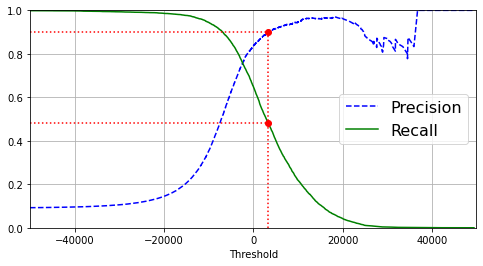

In [28]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

plt.figure(figsize=(8, 4))

# plot precision and recall curves vs decision threshold
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# plot threshold corresponding to 90% precision
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')

# plot precision level up to 90% precision threshold
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')

# plot recall level up to 90% precision threshold
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')

# plot points on precision and recall curves corresponding to 90% precision threshold
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')

plt.show()

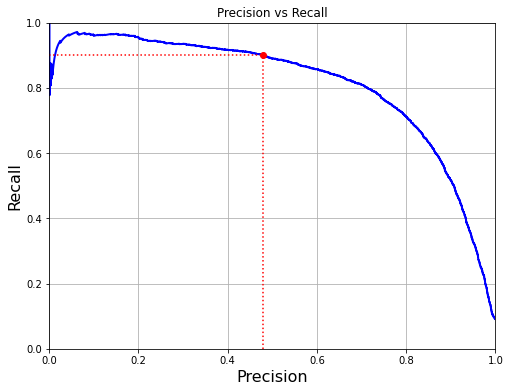

In [29]:
plt.figure(figsize=(8, 6))

# plot precision vs recall
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)

# style the plot
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision vs Recall')

# plot 90% precision point
plt.plot([recall_90_precision], [0.9], 'ro')
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')

plt.show()

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90_precision = recall_score(y_train_5, y_train_pred_90)
precision_90, recall_90_precision

(0.9000345901072293, 0.4799852425751706)